# 死亡事故の分布の分析

In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series,DataFrame
import pandas as pd

# 可視化モジュール
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習モジュール
import sklearn

# 小数第３まで表示
%precision 3

'%.3f'

In [2]:
#ファイルの読み込み
data=pd.read_csv('data_datetime.csv',parse_dates=[0])
data2=data
#factor1がunspecifiedな行を削除
data=data[data['CONTRIBUTING FACTOR VEHICLE 1'] !='Unspecified']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
list_Cont=list((data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().index)[:20])
list_Street=list((data['ON STREET NAME'].value_counts().index)[:1000])
list_Vehicle=list((data['VEHICLE TYPE CODE 1'].value_counts().index)[:13])

In [59]:
data4=data
data4['hour']=data['DATETIME'].dt.hour
data4['month']=data['DATETIME'].dt.month
data4['weekday']=data['DATETIME'].dt.weekday
data4['CONTRIBUTING FACTOR']=data4['CONTRIBUTING FACTOR VEHICLE 1'].apply( lambda x: x if x in list_Cont else 'Ohters')
data4['VEHICLE TYPE']=data4['VEHICLE TYPE CODE 1'].apply(lambda x: x if x in list_Vehicle else 'Ohters')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

## 地区と死傷者数・分類の関係

In [8]:
data['BOROUGH'].value_counts()

BROOKLYN         252019
QUEENS           213834
MANHATTAN        207880
BRONX            108798
STATEN ISLAND     37795
Name: BOROUGH, dtype: int64

In [30]:
data['BOROUGH'].value_counts(1)

BROOKLYN         0.307218
QUEENS           0.260670
MANHATTAN        0.253411
BRONX            0.132628
STATEN ISLAND    0.046073
Name: BOROUGH, dtype: float64

In [60]:
killed= data4[data4['NUMBER OF PERSONS KILLED']!=0]
killed['NUMBER OF PERSONS KILLED'].value_counts()

1    677
2     19
3      5
5      1
4      1
Name: NUMBER OF PERSONS KILLED, dtype: int64

In [81]:
injured= data4.dropna(subset=['ON STREET NAME'])[data4['NUMBER OF PERSONS INJURED']!=0]
#injured['NUMBER OF PERSONS INJURED'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(40.450, 41)

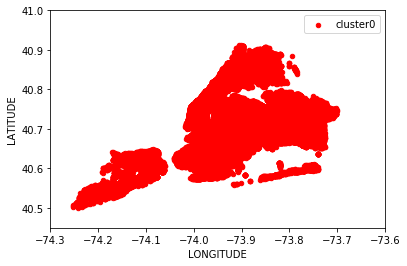

In [63]:
injured.plot.scatter(x='LONGITUDE', y='LATITUDE', color='red', label='cluster0');
plt.xlim(-74.3, -73.6)
plt.ylim(40.45, 41)

In [67]:
killed_TCD=killed[killed['CONTRIBUTING FACTOR VEHICLE 1']=='Traffic Control Disregarded']
killed_FtY=killed[killed['CONTRIBUTING FACTOR VEHICLE 1']=='Failure to Yield Right-of-Way']
killed_PD=killed[killed['CONTRIBUTING FACTOR VEHICLE 1']=='Passenger Distraction']
killed_Alc=killed[killed['CONTRIBUTING FACTOR VEHICLE 1']=='Alcohol Involvement']

(40.450, 41)

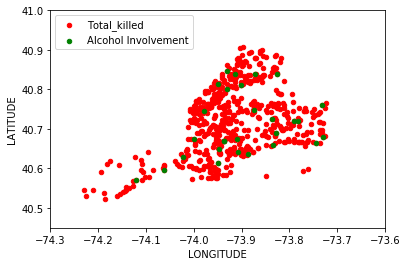

In [72]:
ax=killed.plot.scatter(x='LONGITUDE', y='LATITUDE', color='red', label='Total_killed');
#killed_FtY.plot.scatter(x='LONGITUDE', y='LATITUDE', color='blue', label='Failure to Yield Right-of-Way',ax=ax);
#killed_PD.plot.scatter(x='LONGITUDE', y='LATITUDE', color='yellow', label='Passenger Distraction',ax=ax);
killed_Alc.plot.scatter(x='LONGITUDE', y='LATITUDE', color='green', label='Alcohol Involvement',ax=ax);

plt.xlim(-74.3, -73.6)
plt.ylim(40.45, 41)

### QGisでプロット

In [35]:
killed.to_csv('killed.csv')

In [36]:
killed['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()
#killed['ON STREET NAME'].value_counts().sum()

Driver Inattention/Distraction                           144
Traffic Control Disregarded                              130
Failure to Yield Right-of-Way                             99
Passenger Distraction                                     52
Alcohol Involvement                                       38
Unsafe Speed                                              38
Physical Disability                                       28
Backing Unsafely                                          19
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     17
Following Too Closely                                     15
Driver Inexperience                                       14
View Obstructed/Limited                                   10
Other Vehicular                                            9
Lost Consciousness                                         9
Illness                                                    8
Fell Asleep                                                8
Prescription Medication 

In [94]:
#hour,monthで事故数カウント
killed.groupby('hour')['month'].count()

month=pd.DataFrame(index=[])
weekday=pd.DataFrame(index=[])
for i in range(24):
    #Series=data[data['hour']==i]['month'].value_counts().sort_index()
    month=month.append(killed[killed['hour']==i]['month'].value_counts().sort_index(),ignore_index = True)
    weekday=weekday.append(killed[killed['hour']==i]['weekday'].value_counts().sort_index(),ignore_index = True)
#list_weekday=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
#weekday.columns=list_weekday

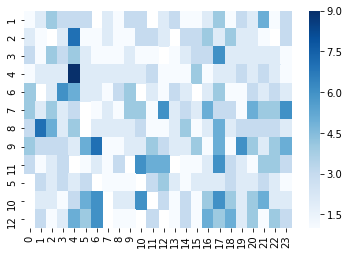

In [116]:
sns.heatmap(month.T,cmap="Blues")

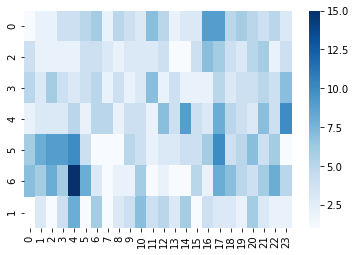

In [95]:
sns.heatmap(weekday.T,cmap="Blues")

意味：死者を出す事故は、金土の深夜に多い

## 金土の深夜の死亡事故を抽出

In [117]:
#金曜23時、土日の0~4時
killed_freq=killed[(((killed['weekday']==5)|(killed['weekday']==6))&\
                   ((killed['hour']<5)&(killed['hour']>=0)))| ((killed['weekday']==4)&(killed['hour']==23))]

In [113]:
killed_freq['hour'].value_counts()

4     25
2     17
3     15
1     14
0     13
23    10
Name: hour, dtype: int64

In [119]:
killed_freq['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

Traffic Control Disregarded       25
Driver Inattention/Distraction    18
Unsafe Speed                      14
Alcohol Involvement               13
Passenger Distraction              7
Failure to Yield Right-of-Way      6
Physical Disability                5
Other Vehicular                    2
Outside Car Distraction            1
Fatigued/Drowsy                    1
Pavement Defective                 1
Lost Consciousness                 1
Name: CONTRIBUTING FACTOR VEHICLE 1, dtype: int64

In [122]:
killed_freq_TCD=killed_freq[killed_freq['CONTRIBUTING FACTOR VEHICLE 1']=='Traffic Control Disregarded']

(40.450, 41)

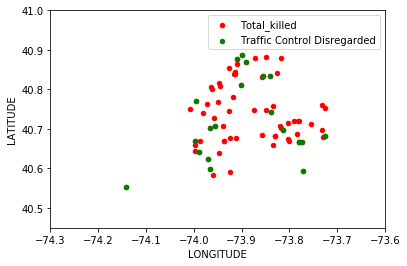

In [123]:
ax=killed_freq.plot.scatter(x='LONGITUDE', y='LATITUDE', color='red', label='Total_killed');
killed_freq_TCD.plot.scatter(x='LONGITUDE', y='LATITUDE', color='green', label='Traffic Control Disregarded',ax=ax);
plt.xlim(-74.3, -73.6)
plt.ylim(40.45, 41)

In [124]:
killed_freq.to_csv('killed_freq.csv')
killed_freq_TCD.to_csv('killed_freq_TCD.csv')

In [87]:
month_inj=pd.DataFrame(index=[])
weekday_inj=pd.DataFrame(index=[])
for i in range(24):
    #Series=data[data['hour']==i]['month'].value_counts().sort_index()
    month_inj=month_inj.append(injured[injured['hour']==i]['month'].value_counts().sort_index(),ignore_index = True)
    weekday_inj=weekday_inj.append(injured[injured['hour']==i]['weekday'].value_counts().sort_index(),ignore_index = True)

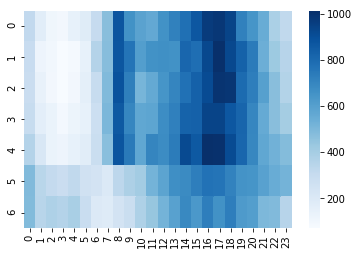

In [85]:
sns.heatmap(weekday_inj.T,cmap="Blues")

In [24]:
#死者事故の事故原因/全事故の事故原因
killed_total=killed['CONTRIBUTING FACTOR VEHICLE 1'].count()
killed_cont=pd.DataFrame(killed['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_index())
killed_cont_r=killed_cont.div(killed_total)
killed_cont_r
total=data['CONTRIBUTING FACTOR VEHICLE 1'].count()
cont=pd.DataFrame(data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_index())
cont_r=cont.div(total)
cont_r

,CONTRIBUTING FACTOR VEHICLE 1
Accelerator Defective,0.000864
Aggressive Driving/Road Rage,0.006398
Alcohol Involvement,0.016371
Animals Action,0.001095
Backing Unsafely,0.061505
Brakes Defective,0.005214
Cell Phone (hand-held),0.000306
Cell Phone (hands-free),0.000381
Driver Inattention/Distraction,0.284492
Driver Inexperience,0.025673


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:179: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


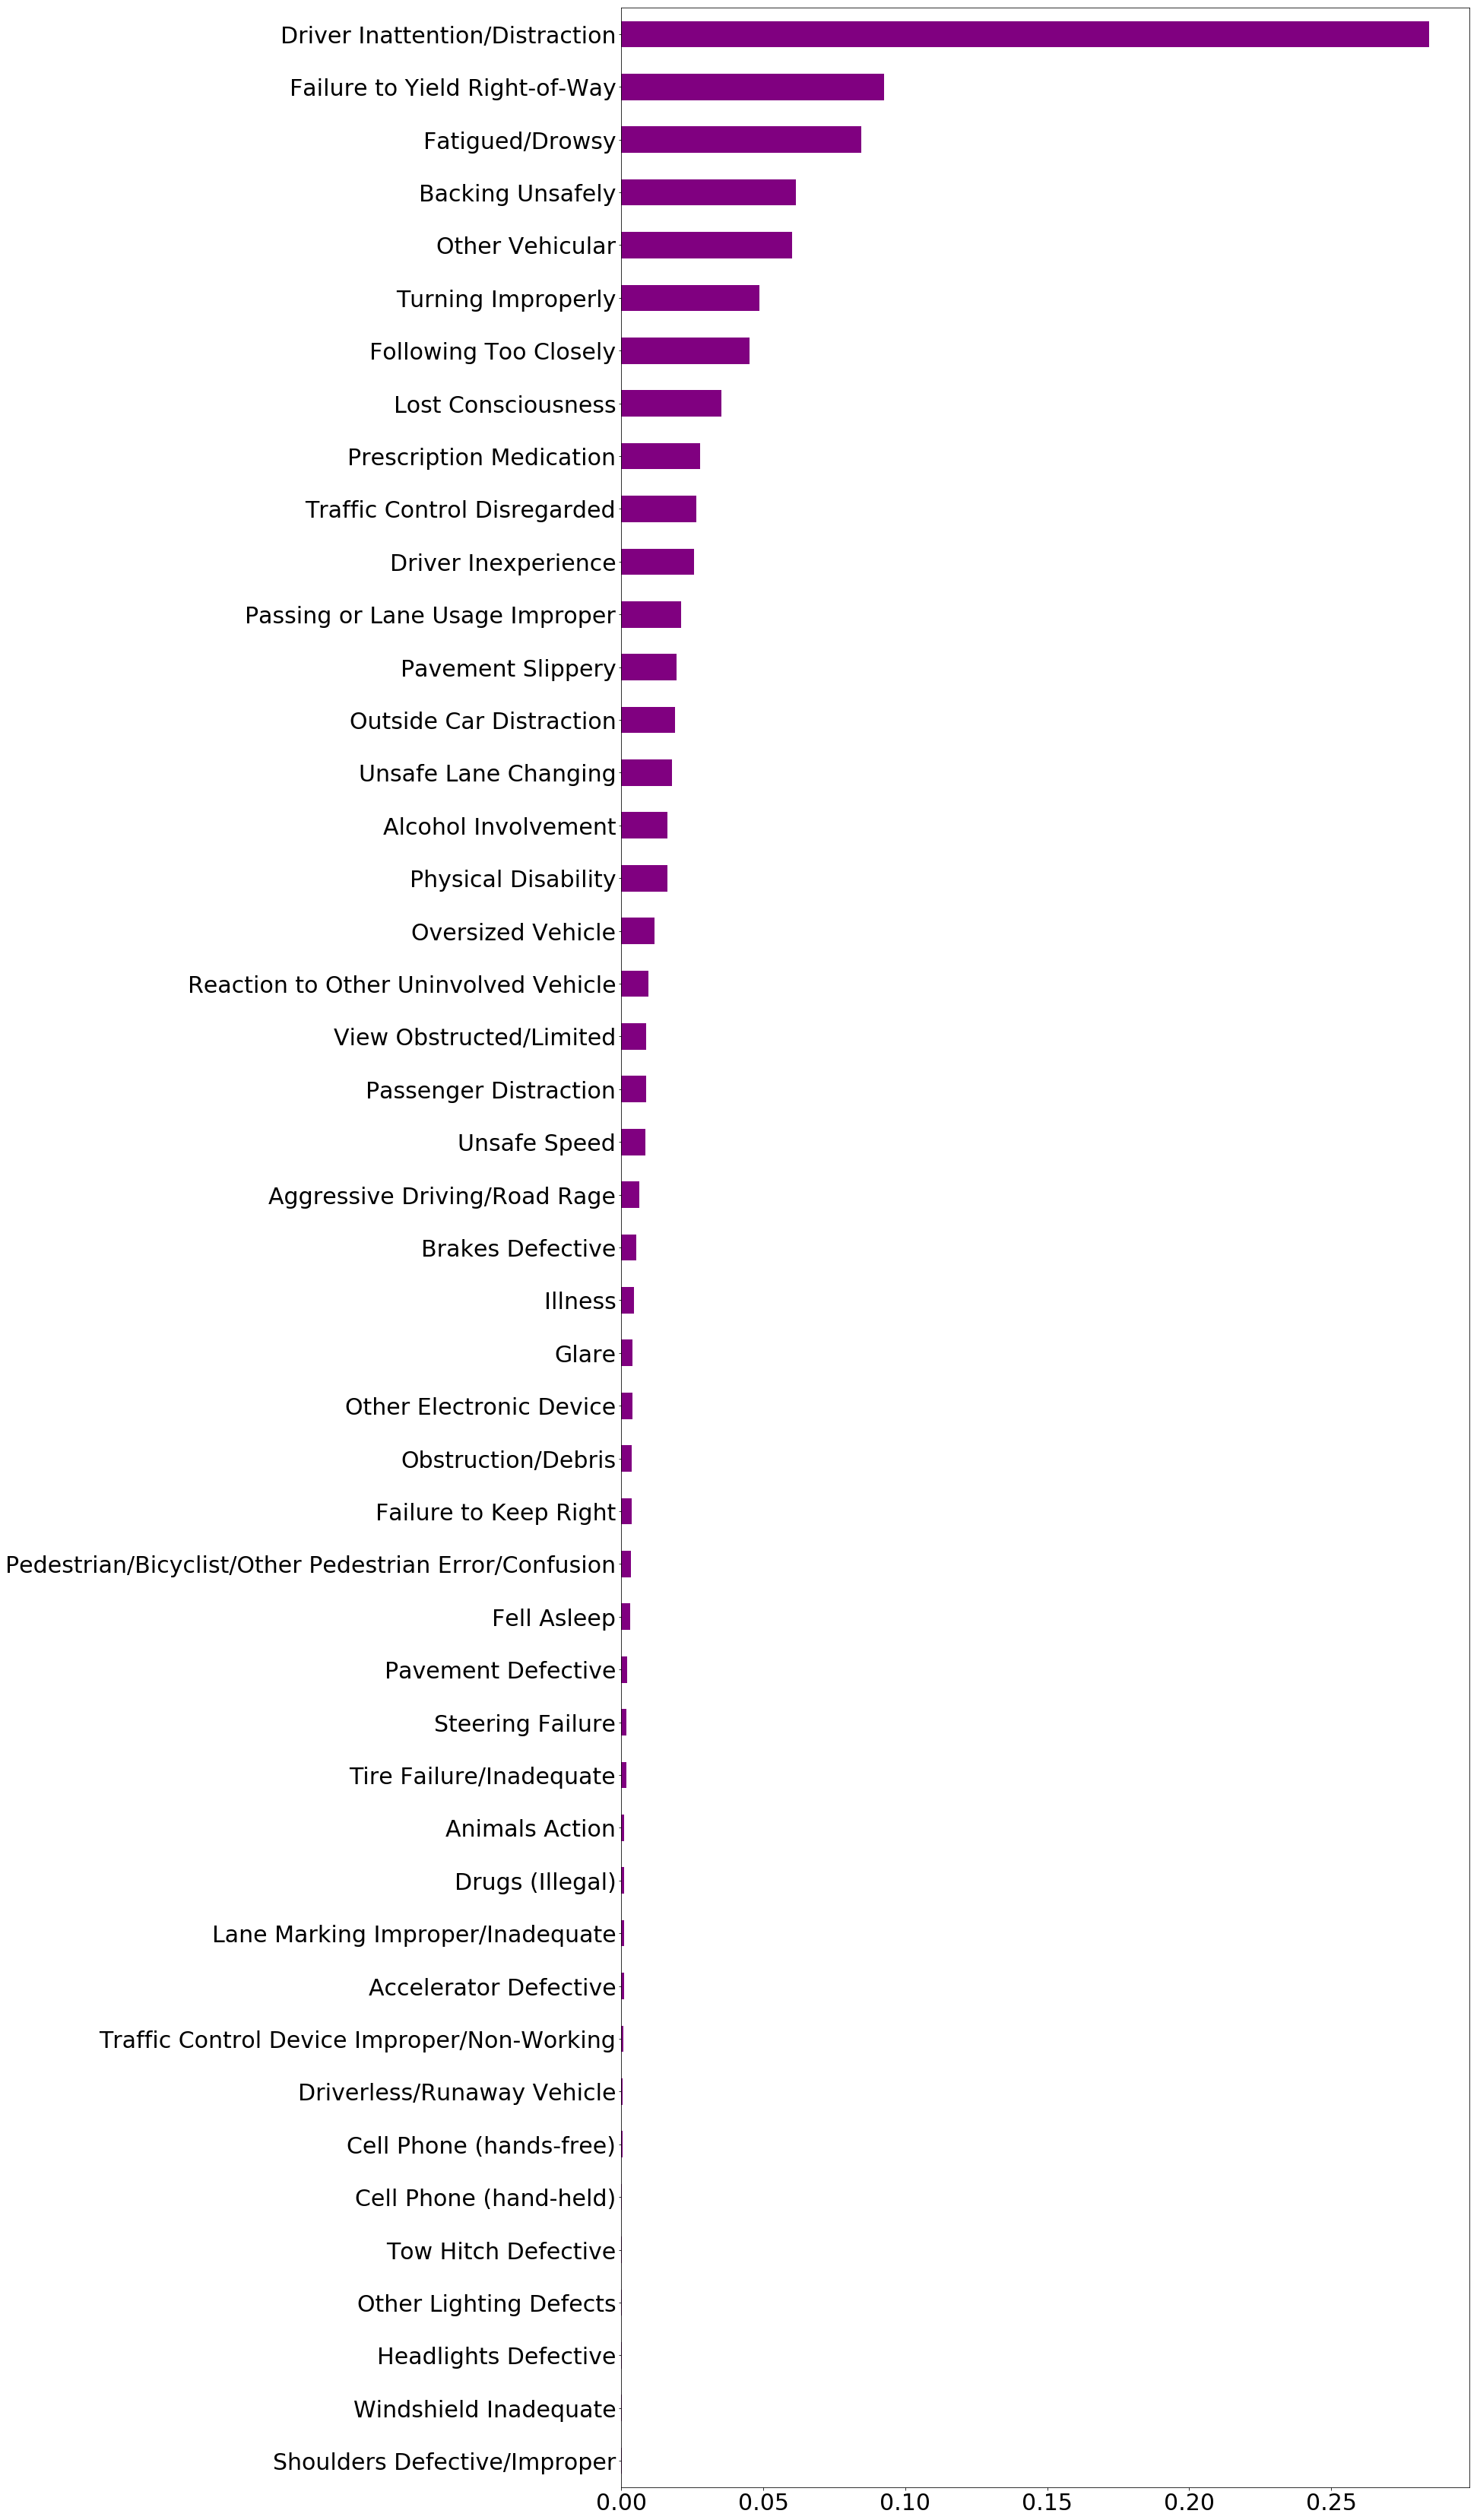

In [29]:
plt.figure(figsize=(20,60),facecolor="white")
cont_r['CONTRIBUTING FACTOR VEHICLE 1'].sort_values().plot(kind='barh',colors='purple',fontsize=30)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:179: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


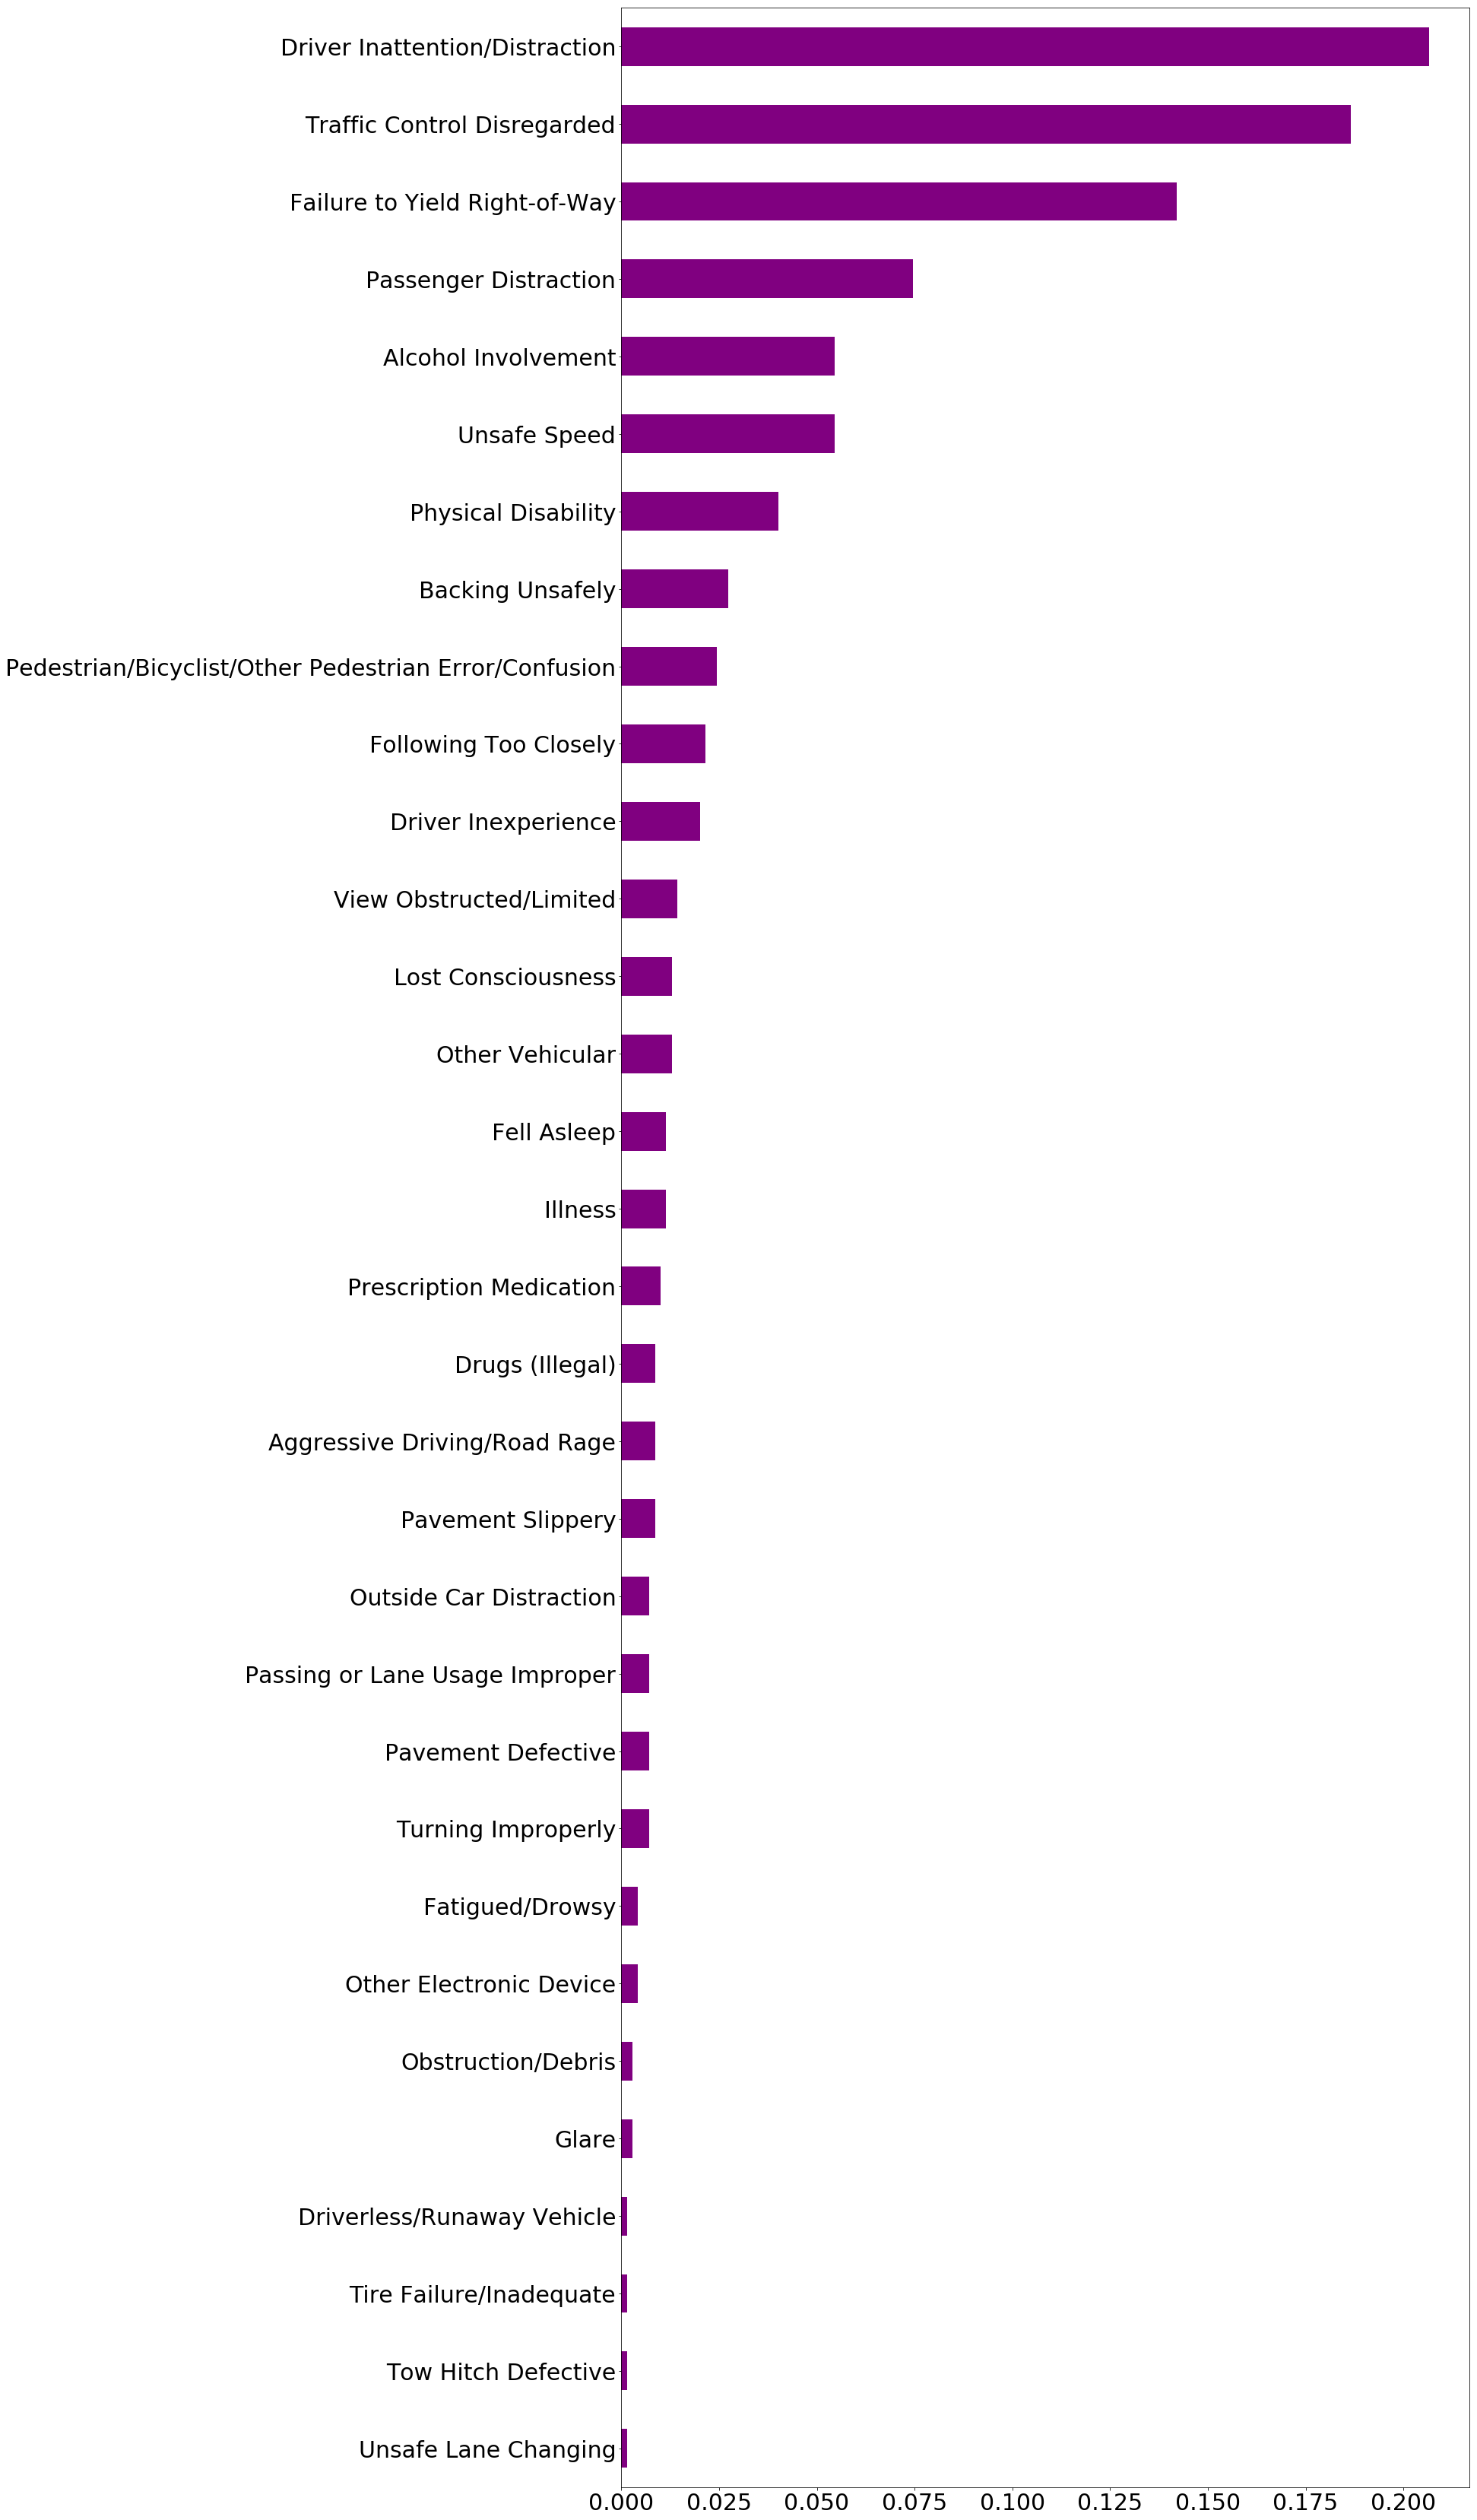

In [30]:
plt.figure(figsize=(20,60),facecolor="white")
killed_cont_r['CONTRIBUTING FACTOR VEHICLE 1'].sort_values().plot(kind='barh',colors='purple',fontsize=30)

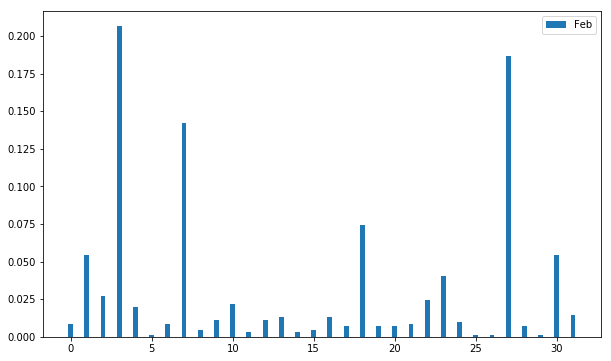

In [26]:
plt.figure(figsize=(10,6),facecolor="white")
#x=list(Feb_Cont.index)
x=np.arange(len(killed_cont_r))
Y1=killed_cont_r['CONTRIBUTING FACTOR VEHICLE 1']
Y2=cont_r['CONTRIBUTING FACTOR VEHICLE 1']

w=0.3
plt.bar(x,Y1,width=w,label='Feb')
#plt.bar(x+w,Y2,width=w,label='Mar')
#plt.xticks(X,x,rotation=90)
plt.legend()

In [16]:
data_Bor_Injured=data.groupby('BOROUGH')['NUMBER OF PERSONS INJURED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF CYCLIST INJURED','NUMBER OF MOTORIST INJURED'].sum()
data_Bor_Killed=data.groupby('BOROUGH')['NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST KILLED'].sum()

In [17]:
data_Bor_Injured

,NUMBER OF PERSONS INJURED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF CYCLIST INJURED,NUMBER OF MOTORIST INJURED
BOROUGH,,,,
BRONX,15184,3357,889,11005
BROOKLYN,34196,7291,3794,23359
MANHATTAN,20857,6775,3597,10640
QUEENS,29662,5614,2101,22232
STATEN ISLAND,4589,605,107,3934


In [18]:
data_Bor_Killed

,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST KILLED
BOROUGH,,,,
BRONX,76,43,4,29
BROOKLYN,165,92,12,60
MANHATTAN,91,63,9,19
QUEENS,145,67,11,67
STATEN ISLAND,32,10,1,22


In [58]:
#各地区ごとの負傷者、死者総計を配列に格納
list_injured = data_Bor_Injured.columns
Injured_total=np.array(list(data_Bor_Injured[list_injured[0]]))
list_killed = data_Bor_Killed.columns
Killed_total=np.array(list(data_Bor_Killed[list_killed[0]]))

In [60]:
#総計で割ることにより割合を求める
data_Bor_Injured_r = data_Bor_Injured.div(Injured_total,axis=0)
data_Bor_Killed_r = data_Bor_Killed.div(Killed_total,axis=0)

In [112]:
data_Bor_Killed_r.iloc[:,1]
#iloc:行列名を指定、loc:行列番号を指定

BOROUGH
BRONX            0.593750
BROOKLYN         0.581081
MANHATTAN        0.764706
QUEENS           0.565385
STATEN ISLAND    0.415094
Name: NUMBER OF PEDESTRIANS KILLED, dtype: float64

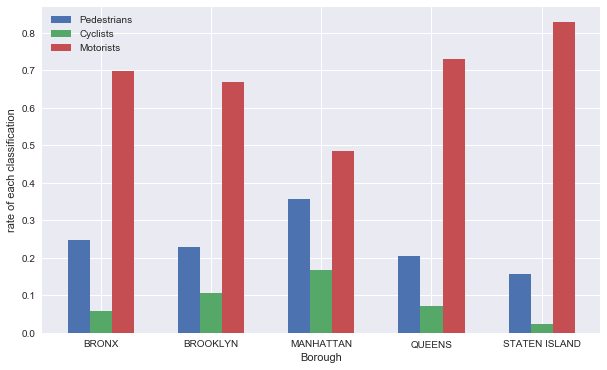

In [107]:
#injuredの地区別割合
plt.figure(figsize=(10,6),facecolor="white")
w=0.2
X = np.arange(5)
plt.bar(X, data_Bor_Injured_r.iloc[:,1], width=w,label='Pedestrians') #Y1
plt.bar(X+w, data_Bor_Injured_r.iloc[:,2],width=w,label='Cyclists') #Y2の棒グラフを隣に書く
plt.bar(X+2*w, data_Bor_Injured_r.iloc[:,3],width=w,label='Motorists') #Y2の棒グラフを隣に書く
plt.xticks(X+ w,[data_Bor_Injured.index[0],data_Bor_Injured.index[1],data_Bor_Injured.index[2],data_Bor_Injured.index[3],data_Bor_Injured.index[4]] )
plt.ylabel('rate of each classification')
plt.xlabel('Borough')
plt.legend()

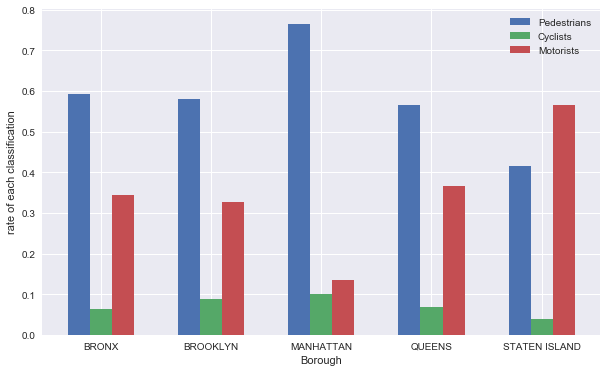

In [108]:
#killed の地域別割合
plt.figure(figsize=(10,6),facecolor="white")
w=0.2
X = np.arange(5)
plt.bar(X, data_Bor_Killed_r.iloc[:,1], width=w,label='Pedestrians') #Y1
plt.bar(X+w, data_Bor_Killed_r.iloc[:,2],width=w,label='Cyclists') #Y2の棒グラフを隣に書く
plt.bar(X+2*w, data_Bor_Killed_r.iloc[:,3],width=w,label='Motorists') #Y2の棒グラフを隣に書く
plt.xticks(X+ w,[data_Bor_Injured.index[0],data_Bor_Injured.index[1],data_Bor_Injured.index[2],data_Bor_Injured.index[3],data_Bor_Injured.index[4]] )
plt.ylabel('rate of each classification')
plt.xlabel('Borough')
plt.legend()

解釈  
- Manhattanでは歩行者の負傷者が多い。
- Staten Islandでは自動車の負傷者が多い。

In [ ]:
ZIP = Collision_data['ZIP CODE']
ZIP_frame = pd.DataFrame(ZIP)
a = pd.concat([ZIP_frame, Dummy], axis=1)